## SEIQR Model of an epidemic outbreak
#### Cedric Chauve, March 28, 2020

In this notebook, I recoded in python the SEIQR model developed by Caroline Colijn in https://github.com/carolinecolijn/SimpleSocialDistancing, with a slight variation that adds the possibility that asymptomatic infectious individuals can be tested to some extant and thus quarantined. I also added code to run this model in the case where we alternate periods of stronger social distancing followed by periods of relaxed constraints.

In [1]:
from scipy.integrate import odeint
import numpy as np                 
import matplotlib.pyplot as plt    
import math

In [2]:
# Plotting functions

# Plotting parameters
# - Compartments that could be plotted
Compartments = ['S','E1','E2','I','Q','R','E2I']
# - Color and legend associated to each compartment
plotColors = {'S':'b','E1':'y','E2':'m','I':'r','Q':'c','R':'g','E2I':'k'}
plotLegend = {'S':'S: Susceptible','E1':'E1: Exposed, not infectious','E2':'E2: Exposed, infectious, asymptomatic',
              'I':'I: Infectious with symptoms','Q':'Q: Quarantined','R':'R: Removed','E2I':'E2+I: Infectious'}
# - Default values of which compartments to plot
plotDefault  = {'S':True,'E1':True,'E2':True,'I':True,'Q':True,'R':True,'E2I':False}
# - Default size of the figure
fsDefault = (12,6)

# Plotting the course of an outbreak
# Data:
# - data: result from our ODEs, dictionary indexed by Compartments
# Epidemiological parameters
# - population N
# - maxt = time frame considered
# Plotting parameters
# - fs is the figure size, a pair (width,height)
# - ticlen is the length between the tick marks on the x-axis
# - title 
# - plotCompartments: which compartments to plot

def plot_outbreak(data,N,maxt,fs,ticlen,title,plotCompartments=plotDefault):
    fig = plt.figure(facecolor='w',figsize=fs)
    ax  = fig.add_subplot(111, facecolor='#dddddd')
        
    t = np.linspace(0, maxt, maxt+1)
    for cmpt in Compartments:
        if plotCompartments[cmpt]:
            ax.plot(t, data[cmpt]/N, plotColors[cmpt],label=plotLegend[cmpt])
            
    ax.set_xlabel('Time (days)')
    plt.xticks(np.arange(0,maxt+1,ticlen),rotation=45)
    ax.set_ylabel('Total/N')
    ax.grid(color = 'w', linestyle = '-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title(title)    
    plt.show()
    
def format_parameters_dictionary(p):
    res=''
    for k,v in p.items():
        res+=str(k)+'='+str(v)+' '
    return(res)

In [3]:
# Default population parameters 
N_default     = 2.4e6 # Total population size
I_0_default   = 50    # Initial number of infected
E1_0_default  = 0
E2_0_default  = 0
Q_0_default   = 0
R_0_default   = 0
init_nosd_default = {'N':N_default,'S':N_default-I_0_default,'E1':E1_0_default,'E2':E2_0_default,
                     'I':I_0_default,'Q':Q_0_default,'R':R_0_default}

# Default length of the outbreak: 8 months
maxt_default = 240

## Basic SEIQR model with no social distancing

A very simple model with 6 compartments: susceptible (S), exposed but not infectious (E1), exposed and infectious but not symptomatic (E2), infectious (I), self-isolated (Q) and recovered (R). Pre-symptomatic transmission occurs in the model (E2 contribute to the force of infection). There is no social distancing.

I (CC) added a parameter *qe2* that would model putting into quarantine E2 individuals (i.e. if tested and positive as infectious). I renamed q as qi. To recover the original model from caroline, qe2 is to be set at 0. I added the R compartment for completeness.

In [4]:
# Main code for the basic SEIQR model with no distanciation
# p: dictionary of parameters
# N: population size
# y: dictionary of values for each compartment
def diffs(y, t, N, p):
    #The vector y holds all the initial values
    S,E1,E2,I,Q,R = y
    dS_dt  = -(p['R0']/(p['D']+1/p['k2']))*(I+E2)*S/N
    dE1_dt = (p['R0']/(p['D']+1/p['k2']))*(I+E2)*S/N-p['k1']*E1
    dE2_dt = p['k1']*E1-p['k2']*E2-p['qe2']*E2
    dI_dt  = p['k2']*E2-p['qi']*I-I/p['D']
    dQ_dt  = p['qi']*I+p['qe2']*E2-Q/p['D'] 
    dR_dt  = Q/p['D']+I/p['D']
    return dS_dt,dE1_dt,dE2_dt,dI_dt,dQ_dt,dR_dt

# We apply the model to a time interval defined by maxt
# init = initial values for each compartment and total population size
#        dictionary indexed by the compartments names but E2I, and by N'
# p = parameters of the model
#     dictionary indexed by R0,k1,k2,qi,qe2,D
def run_SEIQR_model(init,p,maxt):
    N = init['N']
    y = [init['S'],init['E1'],init['E2'],init['I'],init['Q'],init['R']]
    assert (sum(y)==N), "The initial size of the compartments does not equal the total population"

    t   = np.linspace(0, maxt, maxt+1)
    ret = odeint(diffs, y, t, args=(N, p))
    S,E1,E2,I,Q,R = ret.T
    return {'S':S,'E1':E1,'E2':E2,'I':I,'Q':Q,'R':R,'E2I':E2+I}

We first run this basic model with the parameters used in  https://github.com/carolinecolijn/SimpleSocialDistancing, that does not involve any quarantine.

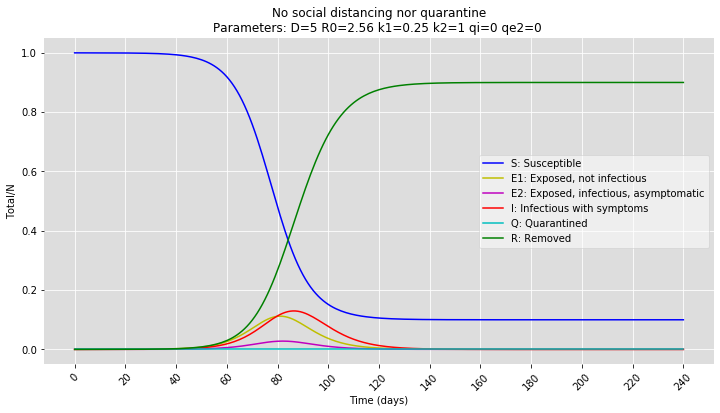

In [5]:
# Example 1. Running the basic model with no quarantine
parameters_nosd_1 = {'D':5,'R0':2.56,'k1':0.25,'k2':1,'qi':0,'qe2':0}
results_nosd_1    = run_SEIQR_model(init_nosd_default,parameters_nosd_1,maxt_default)
title1 = 'No social distancing nor quarantine\nParameters: '+format_parameters_dictionary(parameters_nosd_1)
plot_outbreak(results_nosd_1,init_nosd_default['N'],maxt_default,fsDefault,20,title1)


We now run it with the parameters used in  https://github.com/carolinecolijn/SimpleSocialDistancing, modified to have a quarantining parameter *qi=0.1*.

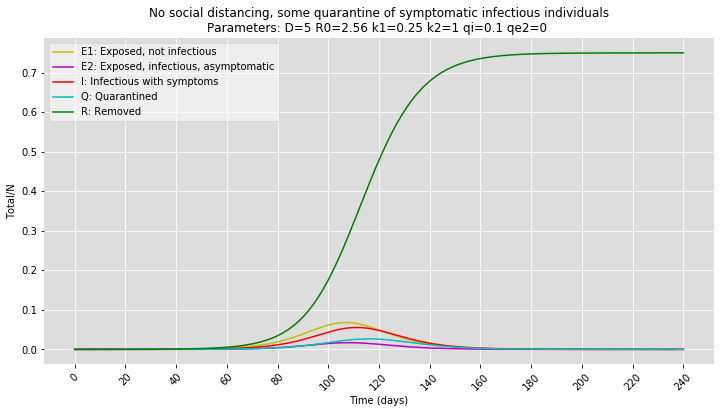

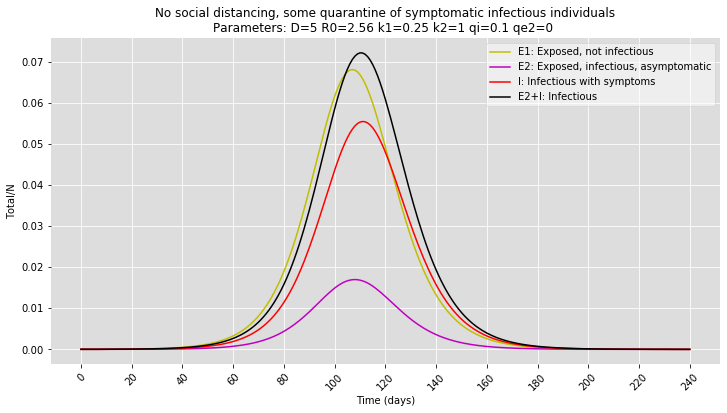

In [6]:
# Example no_sd 2: Running the basic model with quarantine of some symptomatic infectious individuals
parameters_nosd_2 = {'D':5,'R0':2.56,'k1':0.25,'k2':1,'qi':0.1,'qe2':0}
results_nosd_2    = run_SEIQR_model(init_nosd_default,parameters_nosd_2,maxt_default)

title2 = 'No social distancing, some quarantine of symptomatic infectious individuals\nParameters: '+format_parameters_dictionary(parameters_nosd_2)

plotCompartments2 = plotDefault.copy()
plotCompartments2['S']=False
plot_outbreak(results_nosd_2,init_nosd_default['N'],maxt_default,fsDefault,20,title2,plotCompartments2)

plotCompartments2['Q']=False
plotCompartments2['R']=False
plotCompartments2['E2I']=True
plot_outbreak(results_nosd_2,init_nosd_default['N'],maxt_default,fsDefault,20,title2,plotCompartments2)

## SEIQR model with social distancing

Here again, recoded the model developed by Caroline, adding the parameter *qe2* that allows to quarantine E2 and E2d individuals and renamed *q* as *qi*.

In [7]:
# Main code for the SEIQR model with social distancing
# Parameters ar as for diffs (y has one entry per compartment)
def diffs_sd(y, t, N, p):
    #The vector y holds all the initial values
    S,E1,E2,I,Q,R,Sd,E1d,E2d,Id,Qd,Rd = y
    dS_dt  = -(p['R0']/(p['D']+1/p['k2']))*(I+E2+p['f']*(Id+E2d))*S/N-p['r']*S+p['ur']*Sd
    dE1_dt = (p['R0']/(p['D']+1/p['k2']))*(I+E2+p['f']*(Id+E2d))*S/N-p['k1']*E1-p['r']*E1+p['ur']*E1d
    dE2_dt = p['k1']*E1-p['k2']*E2-p['r']*E2+p['ur']*E2d-p['qe2']*E2
    dI_dt  = p['k2']*E2-p['qi']*I-I/p['D']-p['r']*I+p['ur']*Id
    dQ_dt  = p['qi']*I+p['qe2']*E2-Q/p['D']-p['r']*Q+p['ur']*Qd 
    dR_dt  = Q/p['D']+I/p['D']-p['r']*R+p['ur']*Rd
    
    dSd_dt  = -(p['f']*p['R0']/(p['D']+1/p['k2']))*(I+E2+p['f']*(Id+E2d))*Sd/N+p['r']*S-p['ur']*Sd
    dE1d_dt = (p['f']*p['R0']/(p['D']+1/p['k2']))*(I+E2+p['f']*(Id+E2d))*Sd/N-p['k1']*E1d+p['r']*E1-p['ur']*E1d
    dE2d_dt = p['k1']*E1d-p['k2']*E2d+p['r']*E2-p['ur']*E2d-p['qe2']*E2d
    dId_dt  = p['k2']*E2d-p['qi']*Id-Id/p['D']+p['r']*I-p['ur']*Id
    dQd_dt  = p['qi']*Id+p['qe2']*E2d-Qd/p['D']+p['r']*Q-p['ur']*Qd
    dRd_dt  = Id/p['D']+Qd/p['D']+p['r']*R-p['ur']*Rd
    
    return dS_dt,dE1_dt,dE2_dt,dI_dt,dQ_dt,dR_dt,dSd_dt,dE1d_dt,dE2d_dt,dId_dt,dQd_dt,dRd_dt

# We apply the model to a time interval defined by maxt
# init = initial values for each compartment and total population
#        dictionary indexed by the compartments names but E2I
# p = parameters of the model
#     dictionary indexed by R0,k1,k2,qi,qe2,D
def run_SEIQR_sd_model(init,p,maxt):
    N = init['N']
    y = [init['S'],init['E1'],init['E2'],init['I'],init['Q'],init['R'],init['Sd'],init['E1d'],init['E2d'],init['Id'],init['Qd'],init['Rd']]
    # Relaxed assertion to account for numerical precision issues
    assert (N/sum(y)>=0.99), "The initial size of the compartments does not equal the total population"

    t   = np.linspace(0, maxt, maxt+1)
    ret = odeint(diffs_sd, y, t, args=(N, p))
    S,E1,E2,I,Q,R,Sd,E1d,E2d,Id,Qd,Rd = ret.T
    return {'S':S+Sd,'E1':E1+E1d,'E2':E2+E2d,'I':I+Id,'Q':Q+Qd,'R':R+Rd,'E2I':E2+I+E2d+Id}

We first run the model with the parameters of Caroline's notebook but a milder social distancing factor *f=0.7* instead of *f=0.6*.

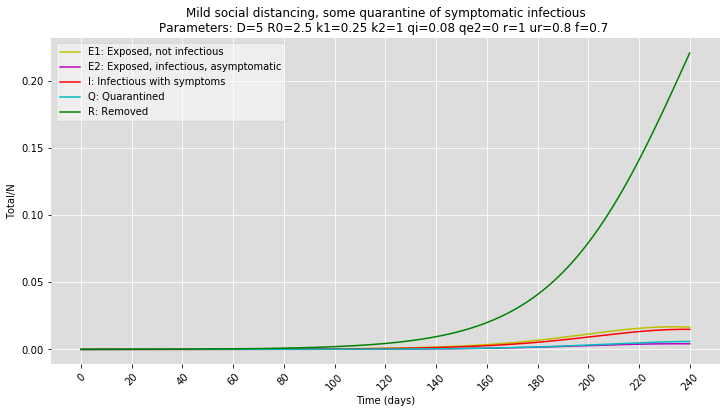

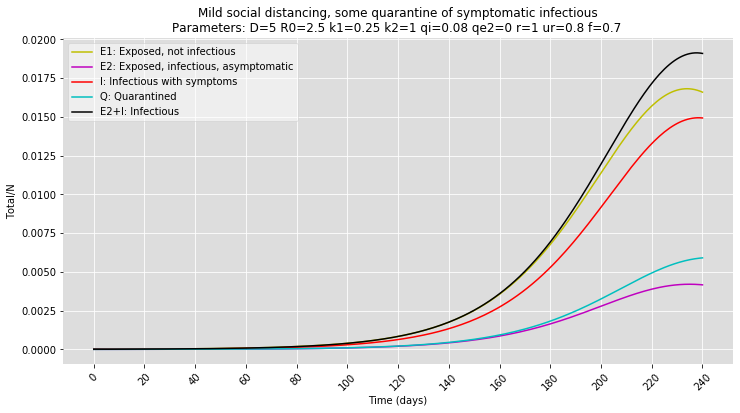

In [8]:
# Example sd 1. First run, no quarantine of E2 individuals, very mild social distancing

parameters_sd_1 = {'D':5,'R0':2.5,'k1':0.25,'k2':1,'qi':0.08,'qe2':0,'r':1,'ur':0.8,'f':0.7}

fsi1  = parameters_sd_1['r']/(parameters_sd_1['r']+parameters_sd_1['ur'])
nsi1  = 1-fsi1
maxt1 = maxt_default
N  = N_default
i0 = I_0_default
init1 = {'N':N,'S':nsi1*(N-i0), 'E1':0.4*nsi1,    'E2':0.1*nsi1*i0, 'I':0.5*nsi1*i0, 'Q':0, 'R':0,
               'Sd':fsi1*(N-i0),'E1d':0.4*fsi1*i0,'E2d':0.1*fsi1*i0,'Id':0.5*fsi1*i0,'Qd':0,'Rd':0}

results_sd_1 = run_SEIQR_sd_model(init1,parameters_sd_1,maxt1)

title1 = 'Mild social distancing, some quarantine of symptomatic infectious\nParameters: '+format_parameters_dictionary(parameters_sd_1)

plotCompartments1 = plotDefault.copy()
plotCompartments1['S']=False
plot_outbreak(results_sd_1,init1['N'],maxt1,fsDefault,20,title1,plotCompartments1)

plotCompartments1['R']=False
plotCompartments1['E2I']=True
plot_outbreak(results_sd_1,init1['N'],maxt1,fsDefault,20,title1,plotCompartments1)


We add the possibility quanrantine E2 individuals at half the rate of I individuals. 

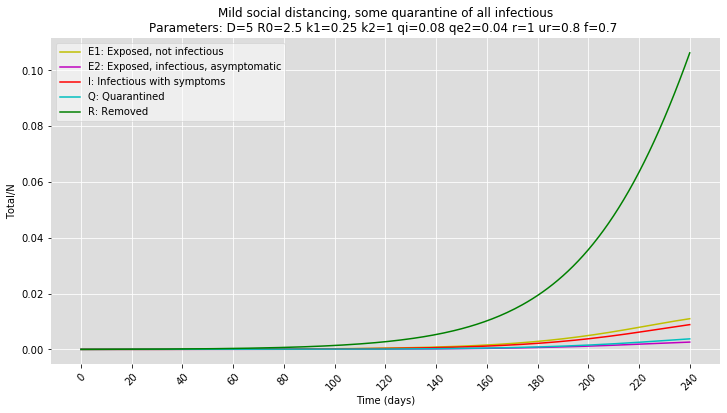

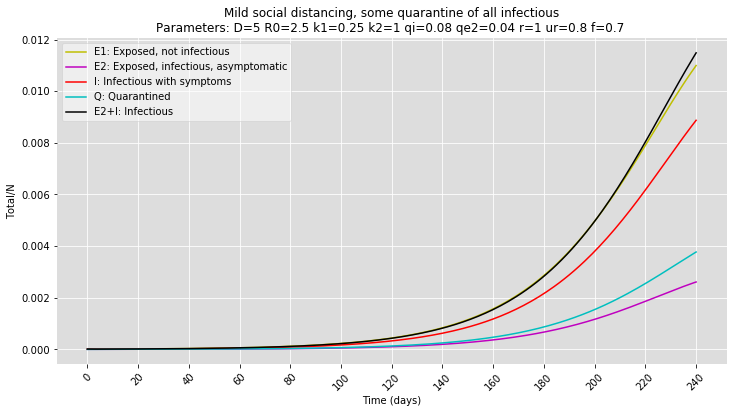

In [9]:
# Example sd 2. Running the model with qe2>0
parameters_sd_2 = {'D':5,'R0':2.5,'k1':0.25,'k2':1,'qi':0.08,'qe2':0.04,'r':1,'ur':0.8,'f':0.7}

init2 = init1.copy()
maxt2 = maxt1

results_sd_2 = run_SEIQR_sd_model(init2,parameters_sd_2,maxt2)

title2 = 'Mild social distancing, some quarantine of all infectious\nParameters: '+format_parameters_dictionary(parameters_sd_2)

plotCompartments2 = plotDefault.copy()
plotCompartments2['S']=False
plot_outbreak(results_sd_2,init2['N'],maxt2,fsDefault,20,title2,plotCompartments2)

plotCompartments2['R']=False
plotCompartments2['E2I']=True
plot_outbreak(results_sd_2,init2['N'],maxt2,fsDefault,20,title2,plotCompartments2)

## SEIQR model with social distancing over time slices

Last, I added the possibility to run the model by time slices, each slice being defined by 4 parameters:
- a duration,
- a value for the parameter *f* that models social distancing, 
- a value for each of the quarantining parameters *qi* and *qe2*

In [10]:
# We apply the model along time slices, each characterized by a duration, an  value for f, qi and qe2
# slices is a list of tuples (t,f,qi,qe2)
def run_SEIQR_sd_model_sliced(init,p,slices):
    N = init['N']
    y = [init['S'],init['E1'],init['E2'],init['I'],init['Q'],init['R'],init['Sd'],init['E1d'],init['E2d'],init['Id'],init['Qd'],init['Rd']]
    # Relaxed assertion to account for numerical precision issues
    assert (N/sum(y)>=0.99), "The initial size of the compartments does not equal the total population"

    COMPARTMENTS = [[] for x in y]
    for (d,f,qi,qe2) in slices:
        t = np.linspace(0,d,d+1)
        p_current = p.copy()
        p_current['f']   = f
        p_current['qi']  = qi
        p_current['qe2'] = qe2
        ret = odeint(diffs_sd, y, t, args=(N, p_current))
        RES_ODE = list(ret.T)
        y = [C[d] for C in RES_ODE]
        for i in range(len(COMPARTMENTS)):
            COMPARTMENTS[i].append(RES_ODE[i][0:d])
    RES_aux = []
    for i in range(len(COMPARTMENTS)):
        RES_aux.append(np.concatenate(COMPARTMENTS[i]))
    offset = 6
    RES = {'S':  RES_aux[0]+RES_aux[0+offset],
            'E1': RES_aux[1]+RES_aux[1+offset],
            'E2': RES_aux[2]+RES_aux[2+offset],
            'I':  RES_aux[3]+RES_aux[3+offset],
            'Q':  RES_aux[4]+RES_aux[4+offset],
            'R':  RES_aux[5]+RES_aux[5+offset],
            'E2I':RES_aux[2]+RES_aux[2+offset]+RES_aux[3]+RES_aux[3+offset]}
    return(RES)

Run of this model where we alternate
- 35 days of mild social distancing (*f=0.8*) and quarantining at rate *qi=0.1* and *qe2=0.05* (e.g. kids at school, most business open)
- 14 days of stronger social distancing (*f=0.6*) and quarantining at rate *qi==qe2=0.1* 9e.g. nop school, reduced business opening)

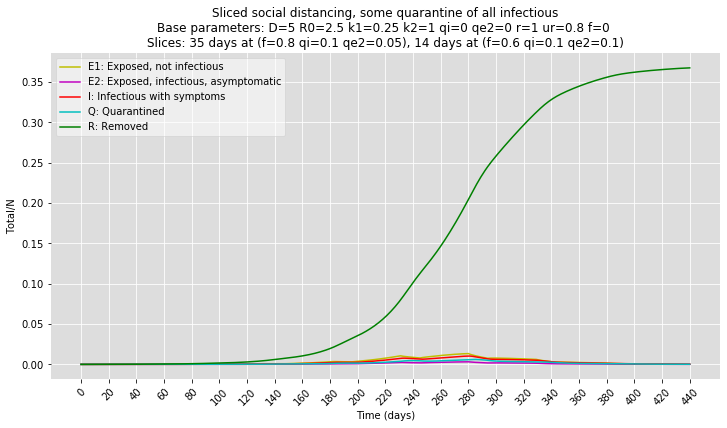

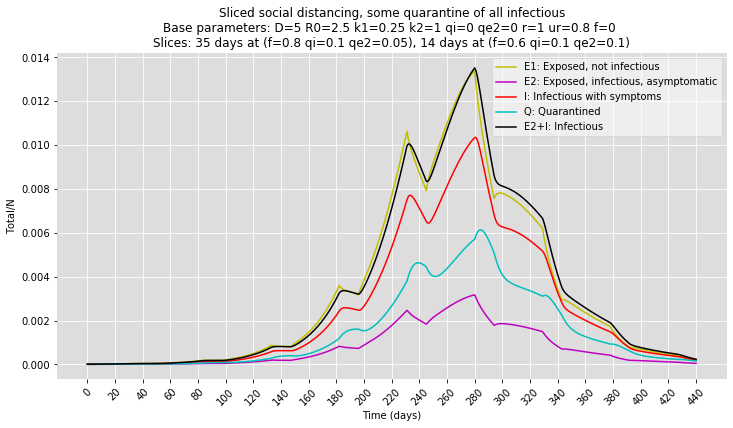

In [11]:
parameters_sd_3 = {'D':5,'R0':2.5,'k1':0.25,'k2':1,'qi':0,'qe2':0,'r':1,'ur':0.8,'f':0}
slices_3 = []
maxt3 = 0
for i in range(9):
    slices_3.append((35,0.8,0.1,0.05))
    slices_3.append((14,0.6,0.1,0.1))
    maxt3+=35+14
maxt3-=1

init3 = init1.copy()

results_sd_3 = run_SEIQR_sd_model_sliced(init3,parameters_sd_3,slices_3)

title3 = 'Sliced social distancing, some quarantine of all infectious\n'
title3 += 'Base parameters: '+format_parameters_dictionary(parameters_sd_3)+'\n'
title3 += 'Slices: 35 days at (f=0.8 qi=0.1 qe2=0.05), 14 days at (f=0.6 qi=0.1 qe2=0.1)'
plotCompartments3 = plotDefault.copy()
plotCompartments3['S']=False
plot_outbreak(results_sd_3,init3['N'],maxt3,fsDefault,20,title3,plotCompartments3)

plotCompartments3['R']=False
plotCompartments3['E2I']=True
plot_outbreak(results_sd_3,init3['N'],maxt3,fsDefault,20,title3,plotCompartments3)

## SEIQR model with time-dependent parameters

I updated the code above in order that all parameters of the model can be provided as time-dependent functions. 
The fature to define time slices is not available, but they can be modelled through the parameters functions.

In [12]:
# To implement time-dependent parameters, i.e. solve a system of PDEs, I discretize the time interval and 
# for each unit time interval, I plug in the values of the parameter for this time interval and solve
# the corresponding system of ODEs.

def run_SEIQR_sd_model_time_dependent(init,p,maxt):
    N = init['N']
    y = [init['S'],init['E1'],init['E2'],init['I'],init['Q'],init['R'],init['Sd'],init['E1d'],init['E2d'],init['Id'],init['Qd'],init['Rd']]
    # Relaxed assertion to account for numerical precision issues
    assert (N/sum(y)>=0.99), "The initial size of the compartments does not equal the total population"

    #[S,E1,E2,I,Q,R,Sd,E1d,E2d,Id,Qd,Rd] = [[x] for x in y]
    COMPARTMENTS = [[x] for x in y]
    T = np.linspace(0,maxt-1,maxt)
    for t in T:
        p_current = {}
        for i,f in p.items():
            p_current[i] = f(t)
        ret = odeint(diffs_sd, y, np.linspace(t,t+1,2), args=(N, p_current))
        RES_ODE = list(ret.T)
        y = [C[1] for C in RES_ODE]
        for i in range(len(COMPARTMENTS)):
            COMPARTMENTS[i].append(RES_ODE[i][1])
    RES_aux = [np.array(C) for C in COMPARTMENTS]
    offset = 6
    RES = {'S':  RES_aux[0]+RES_aux[0+offset],
           'E1': RES_aux[1]+RES_aux[1+offset],
           'E2': RES_aux[2]+RES_aux[2+offset],
           'I':  RES_aux[3]+RES_aux[3+offset],
           'Q':  RES_aux[4]+RES_aux[4+offset],
           'R':  RES_aux[5]+RES_aux[5+offset],
           'E2I':RES_aux[2]+RES_aux[2+offset]+RES_aux[3]+RES_aux[3+offset]}
    return(RES)

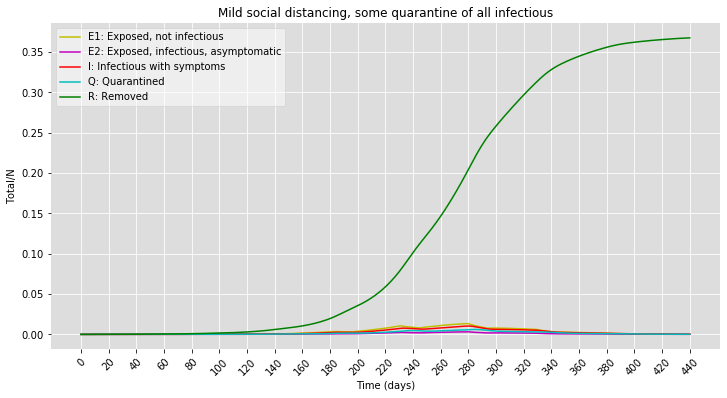

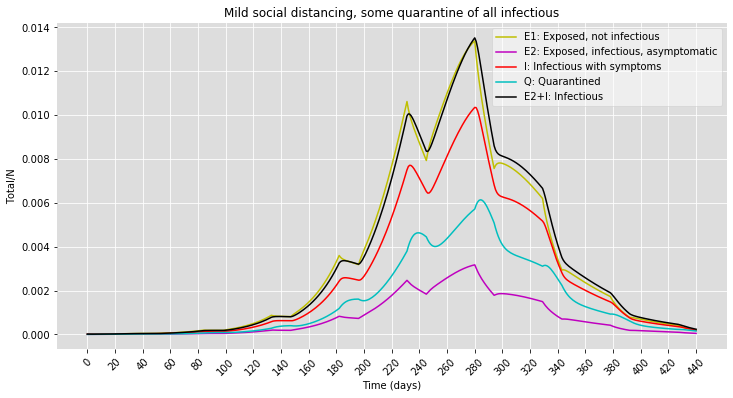

In [14]:
# Rerunning the example sd 3 with time slices implemented with the new code

F4,QI4,QE24 = {},{},{}
t_current = 0
for i in range(9):
    for j in range(35):
        F4[t_current],QI4[t_current],QE24[t_current] = 0.8,0.1,0.05
        t_current+=1
    for j in range(14):
        F4[t_current],QI4[t_current],QE24[t_current] = 0.6,0.1,0.1
        t_current+=1
maxt4=t_current-1

parameters_sd_4 = {'D':  lambda t:5,
                   'R0': lambda t:2.5,
                   'k1': lambda t:0.25,
                   'k2': lambda t:1,
                   'qi': lambda t:QI4[t],
                   'qe2':lambda t:QE24[t],
                   'r':  lambda t:1,
                   'ur': lambda t:0.8,
                   'f':  lambda t:F4[t]}

init4 = init2.copy()

results_sd_4 = run_SEIQR_sd_model_time_dependent(init4,parameters_sd_4,maxt4)
title4 = 'Mild social distancing, some quarantine of all infectious'
plotCompartments4 = plotDefault.copy()
plotCompartments4['S']=False
plot_outbreak(results_sd_4,init4['N'],maxt4,fsDefault,20,title4,plotCompartments4)

plotCompartments4['R']=False
plotCompartments4['E2I']=True
plot_outbreak(results_sd_4,init4['N'],maxt4,fsDefault,20,title4,plotCompartments4)